This notebook attempts to train a (unstacked) Deep O Net to learn the diffusion operator given some initial conditions.

Both the trunk and branch nets are simple MLPs / FFNNs. Increasing the width and depth here helps, due to the idea of neural networks being universal function approximators.

The 1D diffusion equation is:
\begin{split}
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}
\end{split}

In this notebook, the operator $G_0$ learned maps an initial condition to the solution at a later point in time:
\begin{split}
u(x, t_1) = G_0 (u(x, t_0))
\end{split}

This could be generalized as the following, assuming the process is Markovian and an autoregressive approach to timestepping can be taken:
\begin{split}
u(x, t+\Delta t) = G_0 (u(x, t))
\end{split}

In [87]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

jax.default_device(jax.devices("cpu")[0])

In [88]:
# load data
mesh = jnp.load("heat_eqn_data/mesh.npy")
tmesh = jnp.load("heat_eqn_data/tmesh.npy")
solution_trajs = jnp.load("heat_eqn_data/solution_trajectories.npy")

print(mesh.shape)
print(tmesh.shape, tmesh[1])
print(solution_trajs.shape)

(101,)
(1001,) 0.01
(121, 1001, 101)


In [89]:
# some summary statistics of the solution trajectories that will be useful for normalizing the training data later
solution_trajs.max().item(), solution_trajs.min().item()

(3.769486904144287, -3.736118793487549)

In [90]:
# X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))  <- then x2 - 1 to scale between 0 and 1
# X = X_scaled * (max - min) + min
SCALE_MAX = 4
SCALE_MIN = -4
scaled_solutions = (solution_trajs - SCALE_MIN) / (SCALE_MAX - SCALE_MIN) * 2 - 1
scaled_solutions.max().item(), scaled_solutions.min().item()

(0.9423717260360718, -0.9340296983718872)

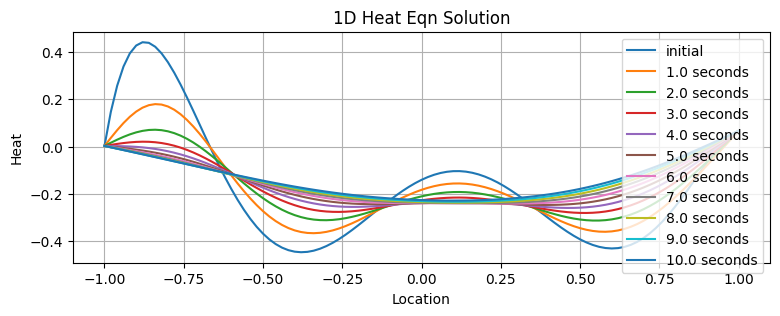

In [91]:
# visualize solution(s)
def plot_trajectories(u, dt:float=0.01, mesh=None):
    plt.figure(figsize=(9,3))
    if mesh is None:
        plt.plot(u[0, :], label="initial")
    else:
        plt.plot(mesh, u[0, :], label="initial")
    walk = int(1/dt)
    idx = walk
    while idx < u.shape[0]:
        if mesh is None:
            plt.plot(u[idx, :], label=f"{idx * dt} seconds")
        else:
            plt.plot(mesh, u[idx, :], label=f"{idx * dt} seconds")
        idx += walk
    plt.title(f"1D Heat Eqn Solution")
    plt.xlabel("Location")
    plt.ylabel("Heat")
    plt.grid()
    plt.legend()

dt = tmesh[1]
plot_trajectories(scaled_solutions[1], dt=dt, mesh=mesh)

(300, 101) (101, 1) (300, 101)
(63, 101) (101, 1) (63, 101)


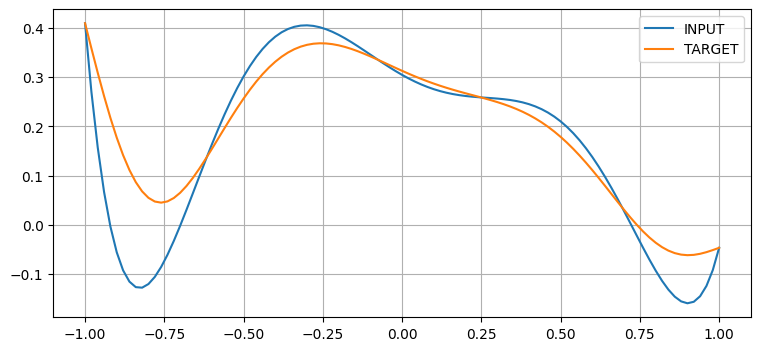

In [92]:
# --> the branch network takes the values of the input to the operator "u"
# in this case the discretization is through space, because this is a PDE
# --> the trunk network takes the query location as input
# --> the training target is the "heat" distribution after a certain amount of time

tstep = 1
jump = int(tstep / dt)

t_interests = [0, 1, 2]
t_interests = [int(x/dt) for x in t_interests]
branch_inputs_train = []
branch_inputs_test = []
trunk_inputs_train = mesh.reshape(-1,1)
trunk_inputs_test = mesh.reshape(-1,1)
outputs_train = []
outputs_test = []
for t_interest in t_interests:
    branch_inputs_train.append(scaled_solutions[:100, t_interest])
    #trunk_inputs_train = mesh.reshape(-1,1)
    outputs_train.append(scaled_solutions[:100, t_interest + jump])

    branch_inputs_test.append(scaled_solutions[100:, t_interest])
    #trunk_inputs_test = mesh.reshape(-1,1)
    outputs_test.append(scaled_solutions[100:, t_interest + jump])
branch_inputs_train = jnp.vstack(branch_inputs_train)
branch_inputs_test = jnp.vstack(branch_inputs_test)
outputs_train = jnp.vstack(outputs_train)
outputs_test = jnp.vstack(outputs_test)

print(
    branch_inputs_train.shape,
    trunk_inputs_train.shape,
    outputs_train.shape
)

print(
    branch_inputs_test.shape,
    trunk_inputs_test.shape,
    outputs_test.shape
)

point = 42
assert point >= 0 and point < branch_inputs_train.shape[0], "JAX departs from NumPy's OOB behavior in that it returns the last known value."
plt.figure(figsize=(9,4))
plt.plot(trunk_inputs_train, branch_inputs_train[point,:], label="INPUT")
plt.plot(trunk_inputs_train, outputs_train[point,:], label="TARGET")
plt.legend()
plt.grid()

In [93]:
# keeping with jax's functional paradigm, we can use a generator function with the yield keyword instead
def data_loader(branch, trunk, target, batchsize:int=10, epoch:int=0):
    key = jax.random.PRNGKey(epoch)
    assert branch.shape[0] == target.shape[0]
    NS = branch.shape[0]
    MAXITR = NS // batchsize
    sarr = jax.random.permutation(key, jnp.arange(NS))
    for itr in range(MAXITR):
        group2yield = jnp.array(range(itr * batchsize, itr * batchsize + batchsize))
        ysarr = sarr[group2yield]
        yield(
            branch[ysarr],
            trunk,
            target[ysarr]
        )

for a, b, c in data_loader(branch_inputs_train, trunk_inputs_train, outputs_train, batchsize=40):
    print(a.shape, b.shape, c.shape)
    break

(40, 101) (101, 1) (40, 101)


In [94]:
class DeepONet1D(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(self, in_size_branch, trunk_width, branch_width, trunk_depth, branch_depth, interact_size, activation, *, key):
        """
        For simplicity, branch and trunk nets are identical MLP here.
        These could be CNNs or anything else in practice.
        """
        b_key, t_key = jr.split(key)
        self.branch_net = eqx.nn.MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=branch_width,
            depth=branch_depth,
            activation=activation,
            key=b_key
        )
        self.trunk_net = eqx.nn.MLP(
            in_size=1,
            out_size=interact_size,
            width_size=trunk_width,
            depth=trunk_depth,
            activation=activation,
            # normally MLPs dont have activation @ final output layer
            # but the trunk net gets it here
            final_activation=activation,
            key=t_key
        )
        self.bias = jnp.zeros((1,))

    def __call__(self, x_branch, x_trunk):
        """Forward pass. 
        
        Note the split branch and trunk inputs, 
        unlike PyTorch or TensorFlow which take a tuple.
        
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)
        
        return should just be a scalar value
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)
        # perform element-wise multiplication
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)
        inner_product += self.bias
        return inner_product[0]

In [ ]:
diffusion_operator = DeepONet1D(
    in_size_branch=101,
    branch_width=101,
    branch_depth=2,
    trunk_width=100,
    trunk_depth=3,
    interact_size=100,
    activation=jax.nn.relu,
    key=jr.PRNGKey(0)
)

optimizer = optax.adam(1e-3)
# set optimizer state, eqx.is_array is also why the bias term is dim (1,)
opt_state = optimizer.init(eqx.filter(diffusion_operator, eqx.is_array))

@eqx.filter_value_and_grad  # changes function signature -> returns loss value and gradient
def loss_fn(model, branch_in, trunk_in, target):
    predictions = jax.vmap(
        jax.vmap(
            model, in_axes=(None, 0)  # vectorize over trunk(s)
        ), in_axes=(0, None)  # vectorize over branch(es)
    )(branch_in, trunk_in)
    mse = jnp.mean(jnp.square(predictions - target))
    return mse

@eqx.filter_jit
def training_step(model, state, branch_in, trunk_in, target):
    loss, grad = loss_fn(model, branch_in, trunk_in, target)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

# Training Loop
loss_history = []
for itr in tqdm(range(10000)):
    loss_history.append([])
    for branch_in, trunk_in, target in data_loader(branch_inputs_train, trunk_inputs_train, outputs_train, batchsize=20, epoch=itr):
        diffusion_operator, opt_state, loss = training_step(
            diffusion_operator, 
            opt_state,
            branch_in,
            trunk_in,
            target
        )
    loss_history[itr].append(loss)
    if itr % 1000 == 0:
        print(f"avg loss, epoch {itr}: {sum(loss_history[itr])/len(loss_history[itr])}")

  0%|          | 3/10000 [00:00<26:14,  6.35it/s]  

avg loss, epoch 0: 0.0276428684592247


 10%|█         | 1003/10000 [01:04<10:41, 14.03it/s]

avg loss, epoch 1000: 3.0269169656094164e-05


 20%|██        | 2002/10000 [02:05<08:02, 16.58it/s]

avg loss, epoch 2000: 9.177810170513112e-06


 30%|███       | 3004/10000 [03:05<06:49, 17.09it/s]

avg loss, epoch 3000: 2.9006845579715446e-05


 40%|████      | 4004/10000 [04:08<06:16, 15.91it/s]

avg loss, epoch 4000: 1.6470694390591234e-05


 50%|█████     | 5003/10000 [05:13<06:18, 13.19it/s]

avg loss, epoch 5000: 3.1538763778371504e-06


 60%|██████    | 6004/10000 [06:17<04:01, 16.53it/s]

avg loss, epoch 6000: 1.7471390947321197e-06


 70%|███████   | 7003/10000 [07:18<03:02, 16.39it/s]

avg loss, epoch 7000: 1.865844569692854e-05


 80%|████████  | 8004/10000 [08:19<02:01, 16.43it/s]

avg loss, epoch 8000: 1.0979500075336546e-05


 90%|█████████ | 9004/10000 [09:22<01:02, 15.83it/s]

avg loss, epoch 9000: 3.964423285651719e-06


100%|██████████| 10000/10000 [10:23<00:00, 16.04it/s]


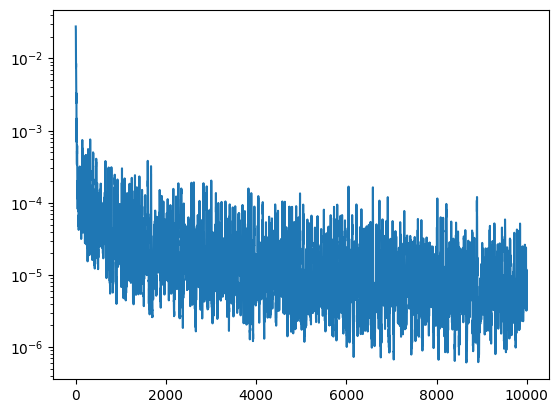

In [102]:
plt.semilogy([sum(ep)/len(ep) for ep in loss_history])

In [103]:
def predict_diffusion(model, mesh, initial_condition):
    return jax.vmap(
        model, in_axes=(None, 0)  # vmap over query coordinates (trunk (mesh))
    )(
        initial_condition,
        mesh
    )


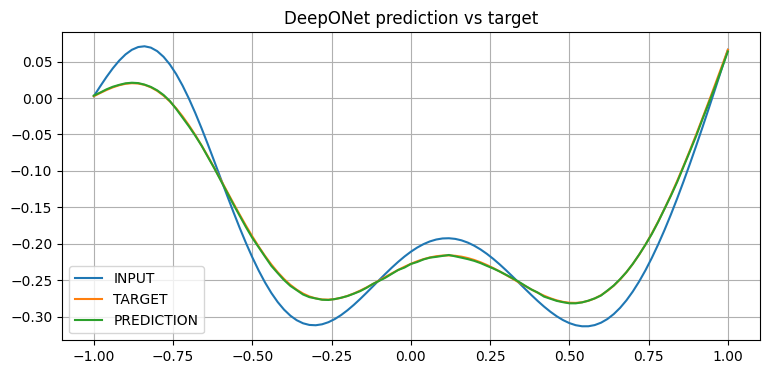

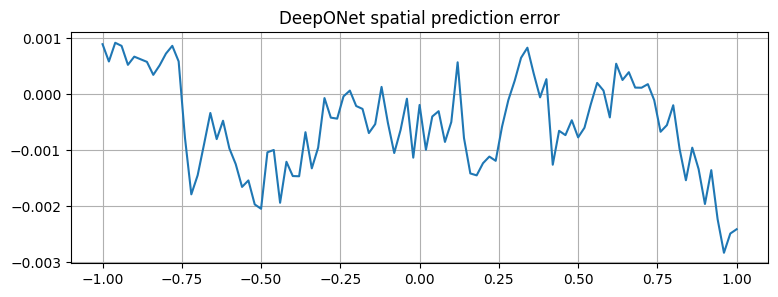

In [108]:
# visualize the prediction for in sample
point = 201  # sample number
assert point >= 0 and point < branch_inputs_train.shape[0], "JAX departs from NumPy's OOB behavior in that it returns the last known value."
plt.figure(figsize=(9,4))
plt.plot(trunk_inputs_train, branch_inputs_train[point,:], label="INPUT")
plt.plot(trunk_inputs_train, outputs_train[point,:], label="TARGET")
prediction = predict_diffusion(diffusion_operator, trunk_inputs_train, branch_inputs_train[point,:])
plt.plot(trunk_inputs_train, prediction, label="PREDICTION")
plt.title("DeepONet prediction vs target")
plt.legend()
plt.grid()
plt.figure(figsize=(9,3))
plt.plot(trunk_inputs_train, prediction - outputs_train[point,:])
plt.title("DeepONet spatial prediction error")
plt.grid()

In [99]:
all_predictions = jax.vmap(
    jax.vmap(
        diffusion_operator,
        in_axes=(None, 0)  # vmap over trunk (query)
    ),
    in_axes=(0, None)  # vmap over branch (spatial)
)(
    branch_inputs_test, trunk_inputs_test
)
# 1000 samples in test set
all_predictions.shape

(63, 101)

In [109]:
# normalized L2 error
# it's kind of a percent error
def normalized_l2_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref) #/ pred.shape[0]
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

# by default, jax vectorizes over axis 0. which works for this case since that is the sample axis
errs = jax.vmap(normalized_l2_error)(all_predictions, outputs_test)
jnp.mean(errs), jnp.std(errs)

(Array(0.05071212, dtype=float32), Array(0.01867137, dtype=float32))

Mean L1 error, spatial: 0.01092
Mean-to-Max L1 error, spatial: 2.517%


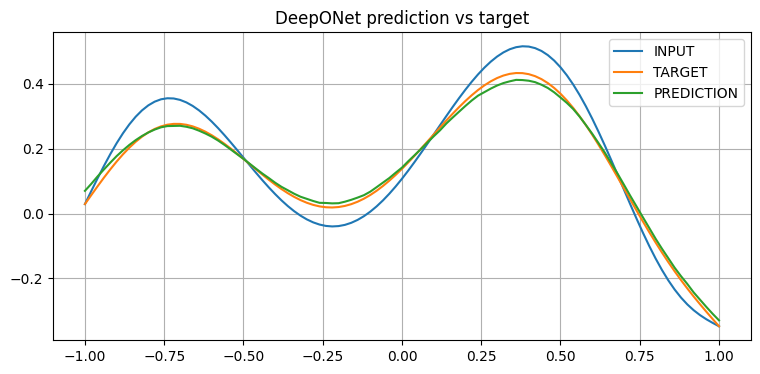

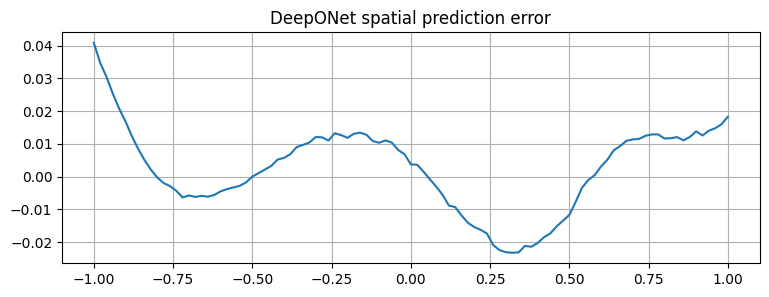

In [129]:
# visualize the prediction for out of sample
point = 30 # sample number
assert point >= 0 and point < branch_inputs_test.shape[0], "JAX departs from NumPy's OOB behavior in that it returns the last known value."
plt.figure(figsize=(9,4))
plt.plot(trunk_inputs_test, branch_inputs_test[point,:], label="INPUT")
plt.plot(trunk_inputs_test, outputs_test[point,:], label="TARGET")
prediction = predict_diffusion(diffusion_operator, trunk_inputs_test, branch_inputs_test[point,:])
plt.plot(trunk_inputs_test, prediction, label="PREDICTION")
plt.title("DeepONet prediction vs target")
plt.legend()
plt.grid()
plt.figure(figsize=(9,3))
plt.plot(trunk_inputs_test, prediction - outputs_test[point,:])
plt.title("DeepONet spatial prediction error")
plt.grid()

mean_l1_err = jnp.mean(jnp.abs(prediction - outputs_test[point,:]))
max_l1_err = jnp.max(jnp.abs(outputs_test[point,:]))
print(f"Mean L1 error, spatial: {mean_l1_err:.5f}")
print(f"Mean-to-Max L1 error, spatial: {mean_l1_err / max_l1_err * 100:.3f}%")